In [1]:
!nvidia-smi

Thu Mar  3 23:01:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   71C    P5    N/A /  N/A |    763MiB /  4096MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
os.chdir('\\Users\\iokhotnikov\\Documents\\Python\\hhl\\test_rig\\code')
from scripts.utils.readers import DataReader, Preprocessor
from scripts.utils.config import FEATURES, FEATURES_NO_TIME, MODELS_PATH

In [4]:
os.chdir('\\Users\\iokhotnikov\\Documents\\Python\\hhl\\test_rig')

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5374547592574918695
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2920257947
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14751836508226768627
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [6]:
def read_data(mode='preprocessed'):
    if mode == 'raw':
        df = DataReader.read_all_raw_data(verbose=True,
                                          features_to_read=FEATURES)
        df = Preprocessor.remove_step_zero(df, inplace=False)
        df.sort_values(by=['DATE', 'TIME'], inplace=True, ignore_index=True)
    if mode == 'processed':
        df = pd.read_csv(os.path.join('data', 'processed',
                                      'combined_timed_data.csv'),
                         parse_dates=True,
                         infer_datetime_format=True,
                         dtype=dict(
                             zip(FEATURES_NO_TIME,
                                 [np.float32] * len(FEATURES_NO_TIME))))
        df[['STEP', 'UNIT', 'TEST',
            'ARMANI']] = df[['STEP', 'UNIT', 'TEST',
                             'ARMANI']].astype(np.uint8)
        df['TIME'] = pd.to_datetime(df['TIME'])
        df['DATE'] = pd.to_datetime(df['DATE'])
    df['RUNNING TIME'] = pd.date_range(start=f'{min(df["DATE"])} 00:00:00',
                                       periods=len(df),
                                       freq='s')
    df['RUNNING DURATION'] = pd.to_timedelta(range(len(df)), unit='s')
    df['RUNNING HOURS'] = (
        pd.to_timedelta(range(len(df)), unit='s').total_seconds() /
        3600).astype(np.float32)
    return df

In [7]:
df = read_data(mode='processed')

In [8]:
test_lengths = []
step_lengths = []
for unit in df['UNIT'].unique():
    for unit_test in df[df['UNIT'] == unit]['TEST'].unique():
        test_lengths.append(
            len(df[(df['UNIT'] == unit) & (df['TEST'] == unit_test)]))
        for step in df[(df['UNIT'] == unit)
                       & (df['TEST'] == unit_test)]['STEP'].unique():
            step_lengths.append(
                len(df[(df['UNIT'] == unit) & (df['TEST'] == unit_test) &
                       (df['STEP'] == step)]))
mean_test_dur_sec = np.mean(test_lengths)
mean_step_dur_sec = np.mean(step_lengths)
print(
    f'Mean test duration {mean_test_dur_sec:.2f} seconds = {mean_test_dur_sec/60:.2f} minutes = {mean_test_dur_sec/3600:.2f} hours'
)
print(
    f'Mean step duration {mean_step_dur_sec:.2f} seconds = {mean_step_dur_sec/60:.2f} minutes = {mean_step_dur_sec/3600:.2f} hours'
)

Mean test duration 3649.24 seconds = 60.82 minutes = 1.01 hours
Mean step duration 111.99 seconds = 1.87 minutes = 0.03 hours


In [9]:
def plot_feature(df, feature):
    plt.figure(figsize=(15, 5), tight_layout=True)
    plt.plot(df['RUNNING HOURS'], df[feature])
    plt.ylabel(feature)
    plt.xlabel('TIME, HOURS')
    plt.show()


def plot_data(df):
    for feature in df.columns:
        if 'RUNNING' not in feature:
            plot_feature(df, feature)

In [10]:
INITIAL_TREND_FEATURES = [
    'M1 CURRENT', 'M1 TORQUE', 'PT4', 'D1 RPM', 'D1 CURRENT', 'D1 TORQUE',
    'M2 RPM', 'M2 Amp', 'M2 Torque', 'CHARGE PT', 'CHARGE FLOW', 'M3 Amp',
    'M3 Torque', 'Servo PT', 'SERVO FLOW', 'HSU IN', 'TT2', 'HSU OUT',
    'M5 Amp', 'M5 Torque', 'M6 RPM', 'M6 Amp', 'M6 Torque', 'M7 RPM', 'M7 Amp',
    'M7 Torque', 'Vibration 1', ' Vibration 2'
]

In [11]:
ENGINEERED_FEATURES = [
    'DRIVE POWER', 'LOAD POWER', 'CHARGE MECH POWER', 'CHARGE HYD POWER',
    'SERVO MECH POWER', 'SERVO HYD POWER', 'SCAVENGE POWER',
    'MAIN COOLER POWER', 'GEARBOX COOLER POWER'
]
df['DRIVE POWER'] = (df['M1 SPEED'] * df['M1 TORQUE'] * np.pi / 30 /
                     1e3).astype(np.float32)
df['LOAD POWER'] = abs(df['D1 RPM'] * df['D1 TORQUE'] * np.pi / 30 /
                       1e3).astype(np.float32)
df['CHARGE MECH POWER'] = (df['M2 RPM'] * df['M2 Torque'] * np.pi / 30 /
                           1e3).astype(np.float32)
df['CHARGE HYD POWER'] = (df['CHARGE PT'] * 1e5 * df['CHARGE FLOW'] * 1e-3 /
                          60 / 1e3).astype(np.float32)
df['SERVO MECH POWER'] = (df['M3 RPM'] * df['M3 Torque'] * np.pi / 30 /
                          1e3).astype(np.float32)
df['SERVO HYD POWER'] = (df['Servo PT'] * 1e5 * df['SERVO FLOW'] * 1e-3 / 60 /
                         1e3).astype(np.float32)
df['SCAVENGE POWER'] = (df['M5 RPM'] * df['M5 Torque'] * np.pi / 30 /
                        1e3).astype(np.float32)
df['MAIN COOLER POWER'] = (df['M6 RPM'] * df['M6 Torque'] * np.pi / 30 /
                           1e3).astype(np.float32)
df['GEARBOX COOLER POWER'] = (df['M7 RPM'] * df['M7 Torque'] * np.pi / 30 /
                              1e3).astype(np.float32)

In [12]:
TREND_FEATURES = ENGINEERED_FEATURES + [
    'PT4', 'HSU IN', 'TT2', 'HSU OUT', 'Vibration 1', ' Vibration 2'
]

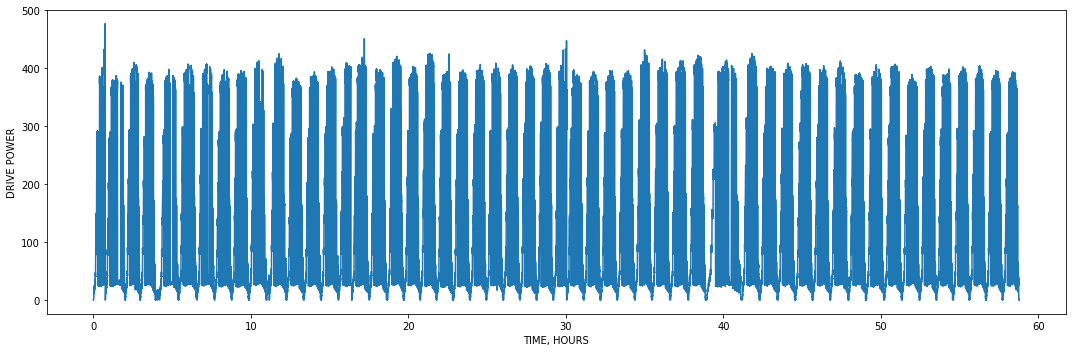

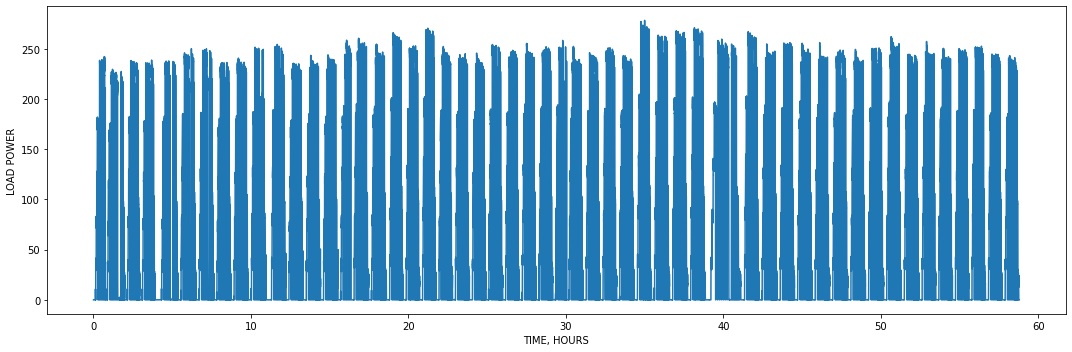

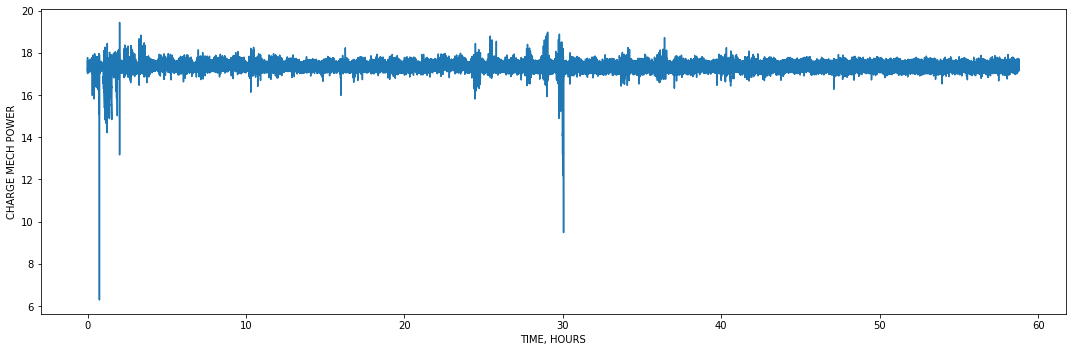

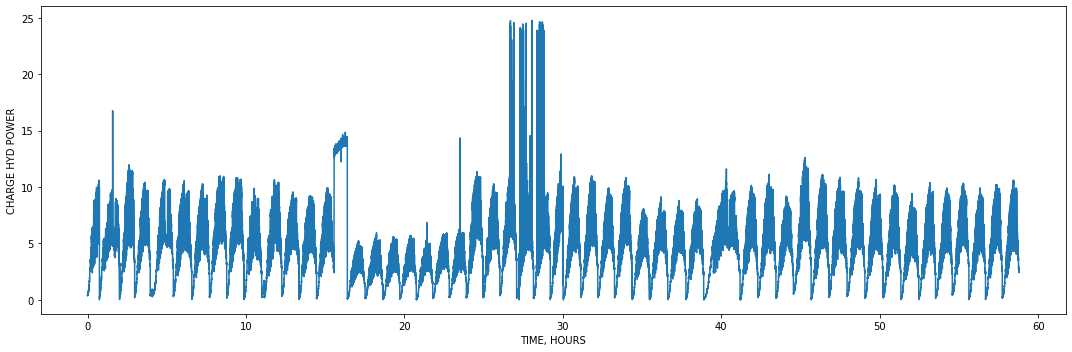

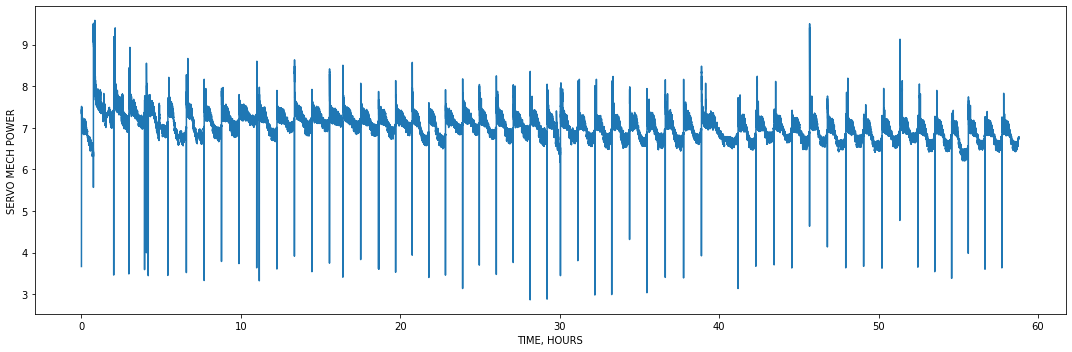

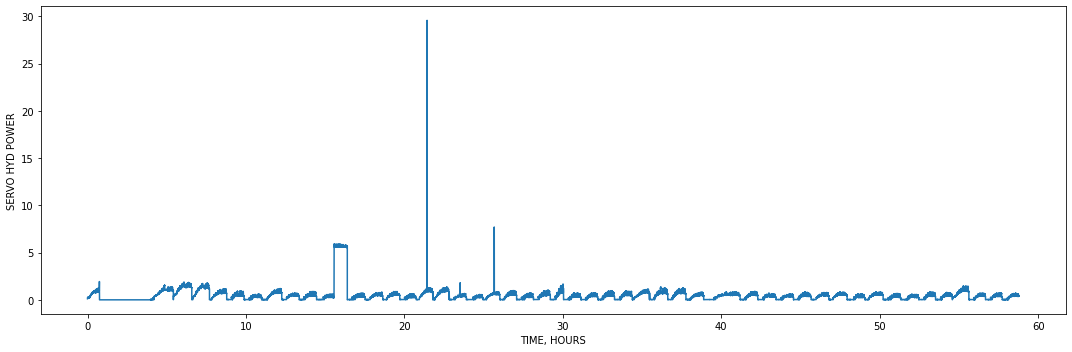

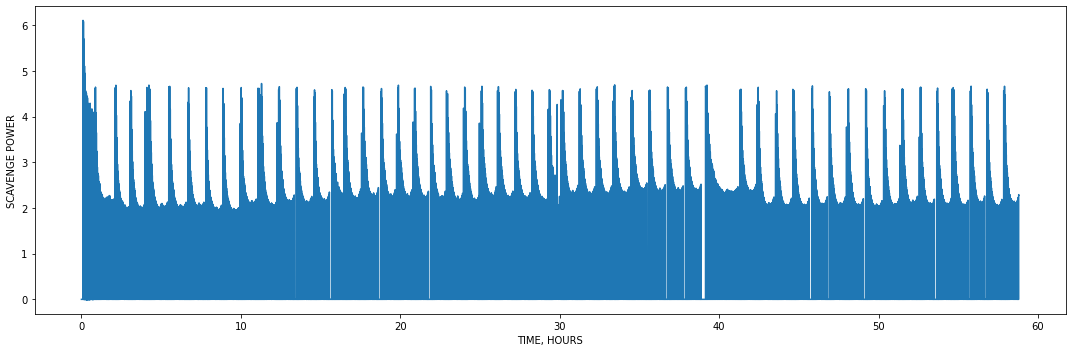

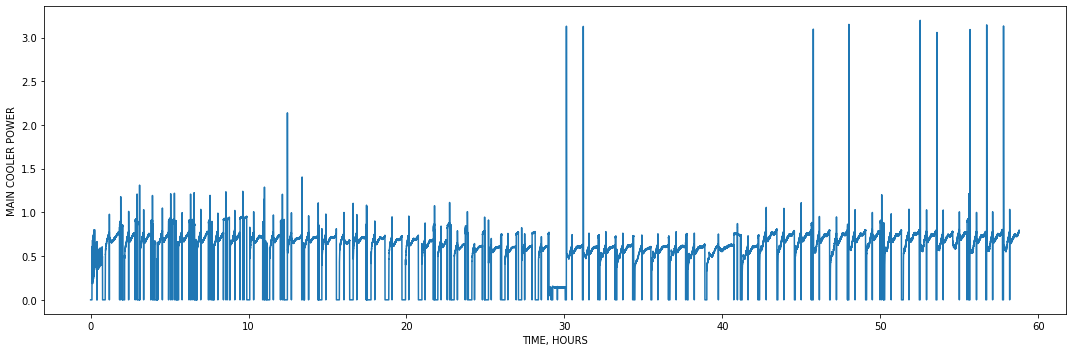

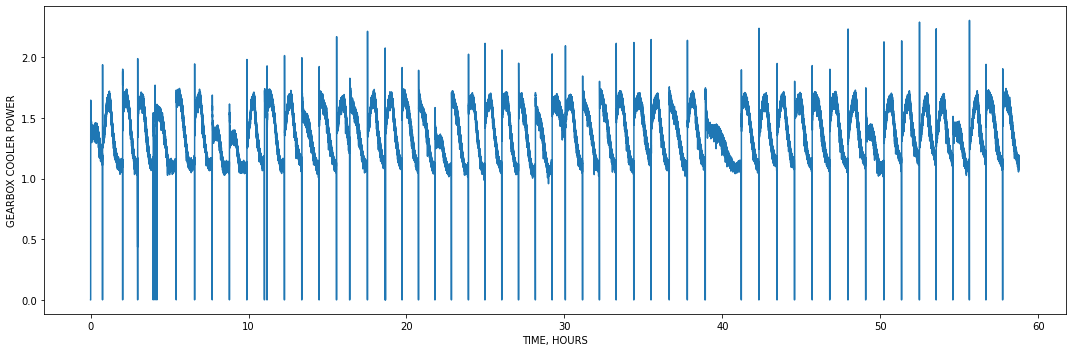

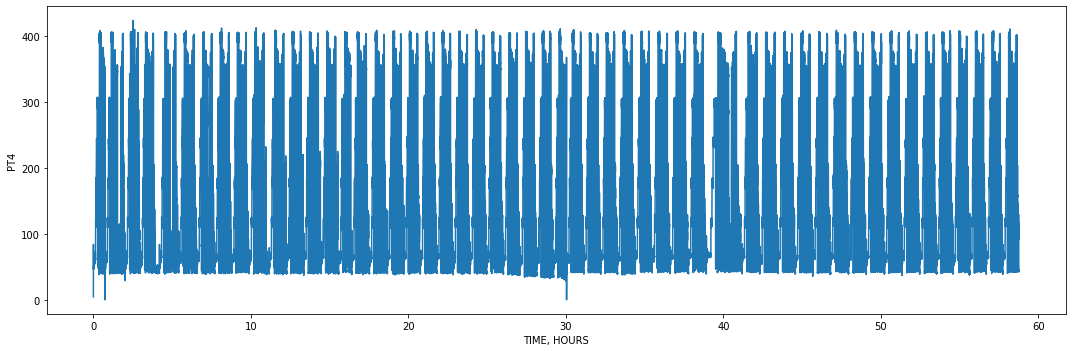

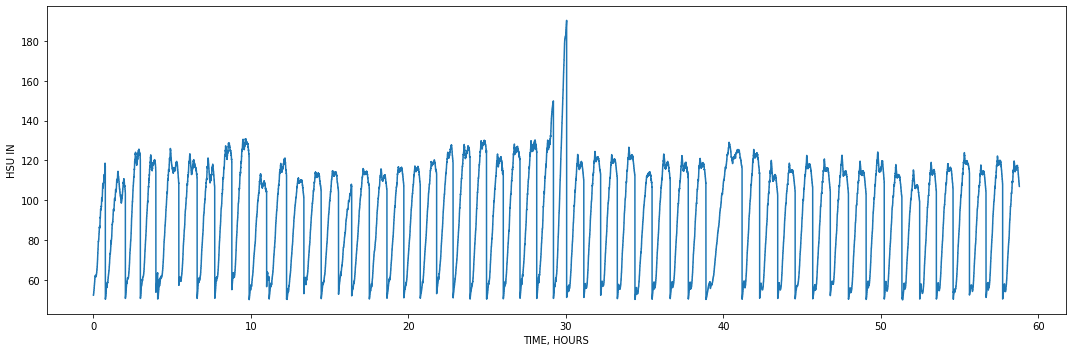

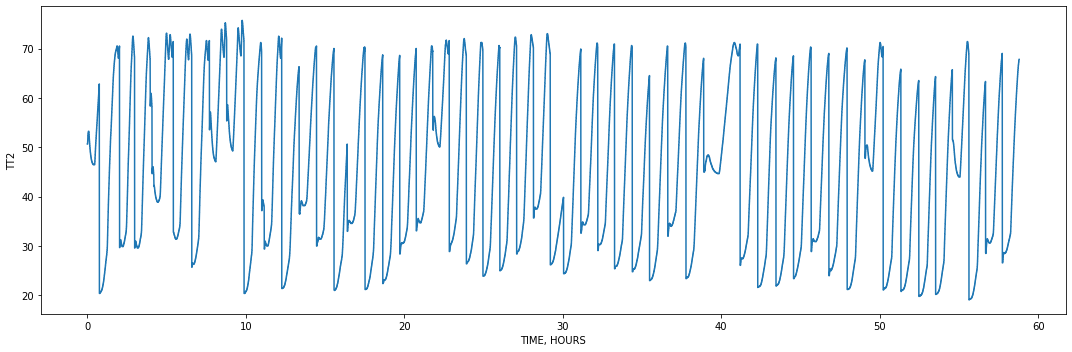

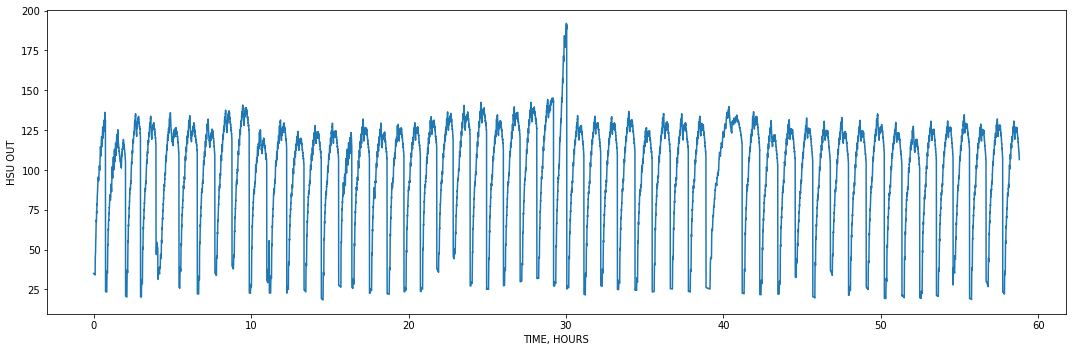

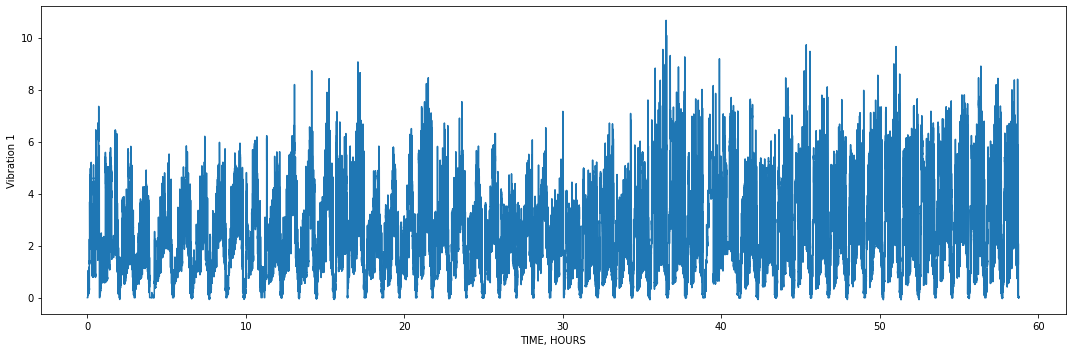

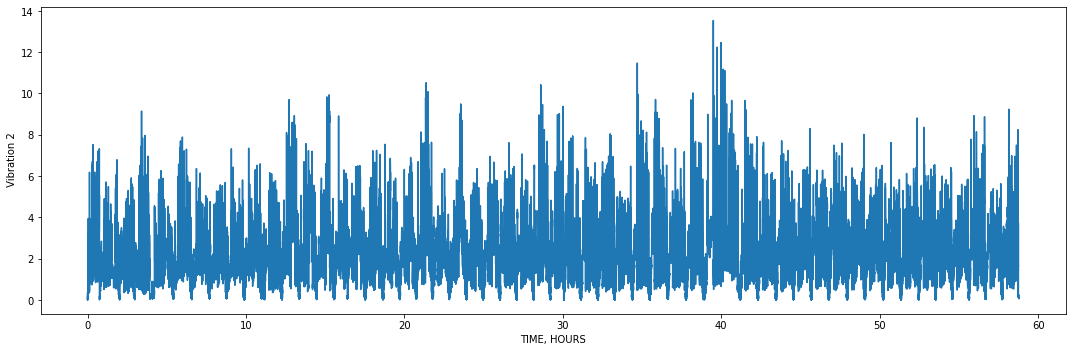

In [13]:
for feature in TREND_FEATURES:
    plot_feature(df, feature)

In [14]:
# data = df[TREND_FEATURES + ['RUNNING HOURS']].copy(deep=True)
# raw_data = df[TREND_FEATURES].copy(deep=True)
# vibration = raw_data.pop('Vibration 1')
# vibration = df.pop('Vibration 1').astype(np.float32)
# pressure = df.pop('PT4').astype(np.float32)
# load_power = df.pop('LOAD POWER').astype(np.float32)
feature = df.pop('SERVO MECH POWER').astype(np.float32)
del df

In [15]:
train_feature = feature[:150000].values
train_feature.shape

(150000,)

In [16]:
train_feature_mean = train_feature.mean()
train_feature_std = train_feature.std()
train_feature = (train_feature - train_feature_mean) / train_feature_std

In [17]:
TIME_STEPS = 120


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

In [18]:
x_train = create_sequences(train_feature.reshape(-1, 1))
print(x_train.shape)

(149881, 120, 1)


In [19]:
model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(filters=32,
                  kernel_size=6,
                  padding='same',
                  strides=2,
                  activation='relu'),
    layers.Dropout(rate=0.25),
    layers.Conv1D(filters=16,
                  kernel_size=6,
                  padding='same',
                  strides=2,
                  activation='relu'),
    layers.Conv1DTranspose(filters=16,
                           kernel_size=6,
                           padding='same',
                           strides=2,
                           activation='relu'),
    layers.Dropout(rate=0.25),
    layers.Conv1DTranspose(filters=32,
                           kernel_size=6,
                           padding='same',
                           strides=2,
                           activation='relu'),
    layers.Conv1DTranspose(filters=1, kernel_size=6, padding='same'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 32)            224       
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 16)            3088      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 60, 16)           1552      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 60, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 120, 32)          3104      
 ranspose)                                              

In [20]:
model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
)


In [21]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 20:
        return lr * tf.math.exp(-0.1)
    elif epoch < 50:
        return lr * tf.math.exp(-0.01)

In [22]:
history = model.fit(x_train,
                    x_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[
                        keras.callbacks.EarlyStopping(
                            patience=10,
                            monitor='val_loss',
                            mode='min',
                            verbose=1,
                            restore_best_weights=True),
                        keras.callbacks.LearningRateScheduler(scheduler,
                                                              verbose=1)
                    ])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
1991/1991 [==============================] - 54s 25ms/step - loss: 0.0487 - val_loss: 0.0421 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
1991/1991 [==============================] - 36s 18ms/step - loss: 0.0230 - val_loss: 0.0326 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
1991/1991 [==============================] - 22s 11ms/step - loss: 0.0180 - val_loss: 0.0295 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
1991/1991 [==============================] - 31s 16ms/step - loss: 0.0156 - val_loss: 0.0342 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
1991/1991 [==============================] - 27s 13ms/step - loss: 0.0145 - val_loss: 0.0212 - lr: 0.0010

Epoch 6: Learn

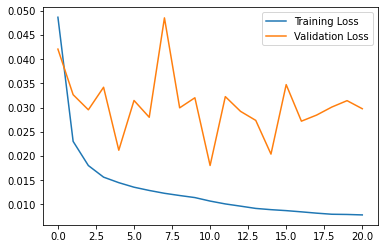

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

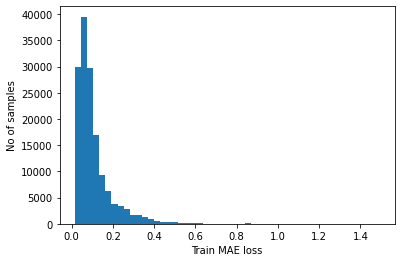

Reconstruction error threshold:  1.4913929


In [24]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

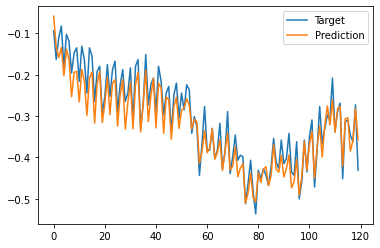

In [25]:
# Checking how the first sequence is learnt
plt.plot(x_train[-1], label='Target')
plt.plot(x_train_pred[-1], label='Prediction')
plt.legend()
plt.show()

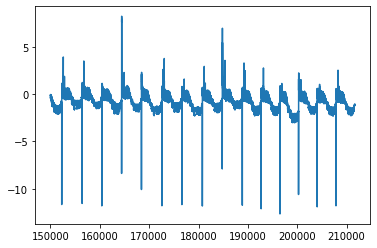

Test input shape:  (61537, 120, 1)


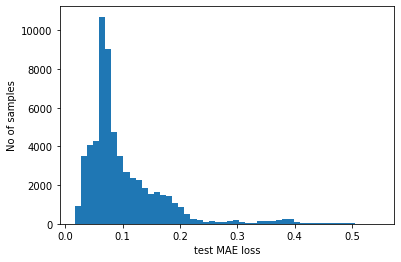

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [26]:
test_feature = feature[150000:]
test_feature = (test_feature - train_feature_mean) / train_feature_std
fig, ax = plt.subplots()
test_feature.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_feature.values.reshape(-1, 1))
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [27]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_feature) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1:data_idx]):
        anomalous_data_indices.append(data_idx)

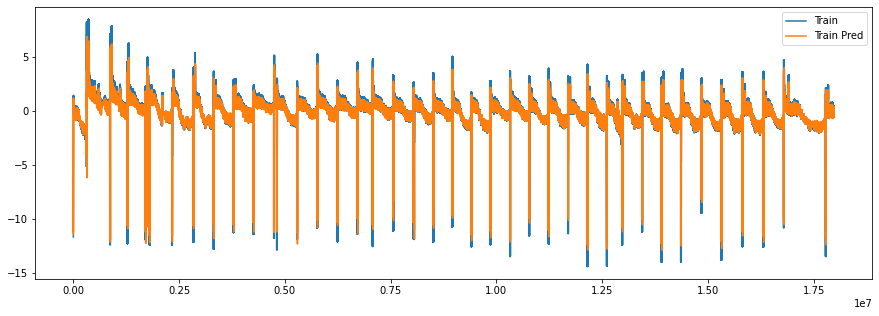

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(x_train.reshape((-1)), label='Train')
plt.plot(x_train_pred.reshape((-1)), label='Train Pred')
plt.legend()
plt.show()